# Trying Random Forest Regression - World Food Program Disaster Relief -

*@XavierTorres*

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import math

In [2]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from warnings import simplefilter

In [3]:
df = pd.read_csv(r'Data_input/OUTPUT_WBI_exposer_cyclones_v10.csv', sep=";")

## Data pre-processing

In [4]:
df.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN', 'NATURE',
       'ISO_TIME', 'COORDS', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', '34KN_ASSETS', '64KN_ASSETS', '96KN_ASSETS', 'CPI',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 'TOTAL_AFFEC

In [5]:
# Arranging columns

df = df[[
    # cols from cyclones
    'SID', 'NAME', 'ISO',  'ISO_TIME', 'COORDS', 'YEAR', 'BASIN', 'SUB BASIN', 'NATURE',
       'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', '34KN_ASSETS', '64KN_ASSETS', '96KN_ASSETS', 'CPI',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS',
    

    # cols from World Bank Indicators:           
    'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
    
    
    # cols from climada:   
    'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 
    
    # Target 
    'TOTAL_AFFECTED']]

In [6]:
df.head(3)

,SID,NAME,ISO,ISO_TIME,COORDS,YEAR,BASIN,SUB BASIN,NATURE,TOTAL_HRS,...,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final,pop_max_34_adj,pop_max_50_adj,pop_max_64_adj,TOTAL_AFFECTED
0,1949163N07145,DELLA,JPN,"['1949-06-21 03:00:00', '1949-06-22 03:00:00',...","[[35.67, 130.99], [38.35, 135.07], [38.82, 136...",1949,WP,WP,TS,0,...,67.666098,NaN,258.911917,2.867878,36.728,Low,1.198300e+07,5.803981e+06,3.320907e+06,194046
1,1950241N23140,JANE,JPN,"['1950-09-02 18:00:00', '1950-09-03 12:00:00',...","[[31.71, 134.12], [38.48, 137.98], [46.7, 152.8]]",1950,WP,WP,ET,6,...,67.666098,NaN,258.911917,2.867878,36.728,Low,3.160822e+07,1.559196e+07,1.018936e+07,642117
2,1951224N12316,CHARLIE,JAM,"['1951-08-17 21:00:00', '1951-08-18 12:00:00']","[[17.34, -75.41], [18.3, -79.4]]",1951,NAm,CS,TS,15,...,64.770000,NaN,152.453647,2.578304,66.231,Low,1.689243e+06,1.687083e+06,1.195052e+06,20200


- **Checking nulls**

In [7]:
# Checking quantity of missing data. Reusing code from Fabi
def null_cols(data):

    """
    This function takes a dataframe df and shows the columns of df that have NaN values
    and the number of them

    """
    nulls = data.isna().sum()
    nulls = nulls[nulls > 0] / len(data) * 100
    nulls = pd.DataFrame(nulls.sort_values(ascending = False))
    nulls = nulls.reset_index().rename(columns = {"index": "Feature", 0: "% Null rows"})
    return nulls

In [8]:
null_cols(df)

,Feature,% Null rows
0,TOTAL_DAMAGE_(000$),31.741294
1,34KN_ASSETS,23.184080
2,64KN_ASSETS,23.184080
3,96KN_ASSETS,23.184080
4,"Air transport, freight (million ton-km)",15.820896
5,TOTAL_DEATHS,13.333333
6,pop_max_64_adj,7.960199
7,pop_max_34_adj,7.960199
8,pop_max_50_adj,7.960199
9,GDP growth (annual %),3.980100


- **BASIN and SUBBASIN**: 'MM' value means missing, and **USA_SSHS** column with value -5 = Unknown [XX]:

In [9]:
df["SUB BASIN"]= df["SUB BASIN"].replace('MM', np.nan) 
df["BASIN"]= df["BASIN"].replace('MM', np.nan) 
df["USA_SSHS"]= df["USA_SSHS"].replace(-5, np.nan) 

- As damage in '000 USD is time-money sensitive, we can use the CPI for that data point to calculate **"Total Damage Adjusted"** 
by dividing Total Damage by the CPI. We then drop columns for Damage and CPI.
CPI meaning = https://en.wikipedia.org/wiki/Consumer_price_index

In [10]:
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)"] / df["CPI"]
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)

In [11]:
df = df.drop(["TOTAL_DAMAGE_(000$)",'CPI'], axis=1)
df["TOTAL_DAMAGE_(000$)_Adjusted"].isna().sum()

319

- Trying to create a calculated column that better represents de relative dimension **of exposed assets**. We have several columns for assets exposed depending of windspeed for 34kn+, 64kn+ and 96kn+. Let's add these columns to create a new column:

In [12]:
df['CALC_assets_emdat'] = df['34KN_ASSETS'] + df['64KN_ASSETS'] + df['96KN_ASSETS']
df = df.drop(['34KN_ASSETS', '64KN_ASSETS','96KN_ASSETS'], axis=1)

 - Extracting **month of cyclone**

In [13]:
df['MONTH'] = df.ISO_TIME.apply(lambda x: x[7:9]).astype(int)

- **Transform 'Income_Level'** categories to ordered integers and **YEAR, BASIN, SUB BASIN and USA_SSHS** into Category Type

In [14]:
#Arnab code
unique_list = df['Income_level_Final'].unique()
incomelevel_to_int = dict(zip(unique_list, [1,2,4,3])) # so we assign['Low' =1, 'Low_Middle' =2, 'High'=4, 'High_Middle'=3]
df['Income_level_Final'] = df['Income_level_Final'].apply(lambda inc_level: incomelevel_to_int[inc_level])

In [15]:
df['YEAR'] = df['YEAR'].astype('category')
df['BASIN'] = df['BASIN'].astype('category')
df['SUB BASIN'] = df['SUB BASIN'].astype('category')
df['NATURE'] = df['NATURE'].astype('category')
df['USA_SSHS'] = df['USA_SSHS'].astype('category')

- **Arranging columns**

In [16]:
df.shape

(1005, 39)

In [17]:
df.columns

Index(['SID', 'NAME', 'ISO', 'ISO_TIME', 'COORDS', 'YEAR', 'BASIN',
       'SUB BASIN', 'NATURE', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DEATHS', 'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 'TOTAL_AFFECTED',
       'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', 'MONTH'],
      dtype='

In [19]:
#taking out from model=    'SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'ISO_TIME',
# Arranging columns

df = df[[
    # cols from cyclones
    'BASIN', 'SUB BASIN', 'NATURE',
       'MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN','TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat',  'TOTAL_DEATHS',
    

    # cols from World Bank Indicators:           
    'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
    
    
    # cols from climada:   
    'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj',
    
    # Target 
    'TOTAL_AFFECTED']]

- **Check SKEWENESS and apply log**

In [20]:
#determine index for continous variables
num_feats = df.dtypes[df.dtypes != 'object'].index

#Calculate skew and sort
skew_feats = df[num_feats].skew().sort_values(ascending = False)
skewness = pd.DataFrame({'Skew': skew_feats})

In [21]:
skewness

,Skew
TOTAL_DEATHS,28.579526
TOTAL_DAMAGE_(000$)_Adjusted,12.376678
Population density (people per sq. km of land area),10.706739
TOTAL_AFFECTED,7.345349
Arable land (hectares per person),5.368166
pop_max_50_adj,4.056652
pop_max_64_adj,3.540787
pop_max_34_adj,3.099740
CALC_assets_emdat,2.863852
"Air transport, freight (million ton-km)",2.689838


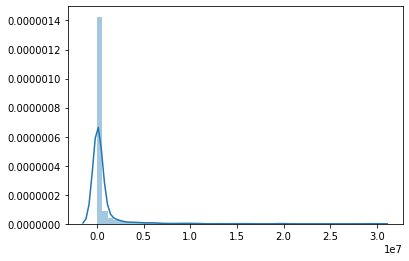

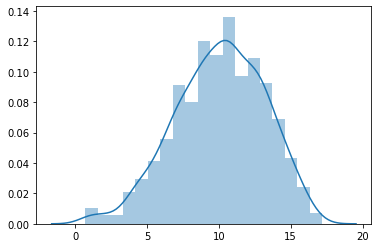

<Figure size 432x288 with 0 Axes>

In [22]:
# Checking distribution for one feature---reusing code from Juber
ax=sns.distplot(df['TOTAL_AFFECTED'].values)

plt.show()
plt.clf()

log_affected=np.log(df['TOTAL_AFFECTED'].values)
ax=sns.distplot(log_affected)

plt.show()
plt.clf()

In [23]:
# Creating list of features to transform, for skew values above 2

feats_to_log = skewness[skewness['Skew'] > 2].index

In [24]:
feats_to_log

Index(['TOTAL_DEATHS', 'TOTAL_DAMAGE_(000$)_Adjusted',
       'Population density (people per sq. km of land area)', 'TOTAL_AFFECTED',
       'Arable land (hectares per person)', 'pop_max_50_adj', 'pop_max_64_adj',
       'pop_max_34_adj', 'CALC_assets_emdat',
       'Air transport, freight (million ton-km)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Net flows from UN agencies US$'],
      dtype='object')

In [25]:
# as log cannot be perfomed to negative numbers, a common technique for handling negative values is to 
# add a constant value to the data prior to applying the log transform. The transformation is 
#therefore log(Y+a) where a is the constant. Some people like to choose a so that min(Y+a) is a very small 
#positive number (like 0.001). Others choose a so that min(Y+a) = 1. For the latter choice, you can show 
# that a = b – min(Y), where b is either a small number or is 1.
# Source : https://blogs.sas.com/content/iml/2011/04/27/log-transformations-how-to-handle-negative-data-values.html

for item in feats_to_log:
    #df[item]=np.log((df[item] + 1 - df[item].min()).values)
    df[item] = df[item].apply(lambda x: np.log(x) if x>0 else 0)
    

C:\Users\torre\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [26]:
df[feats_to_log].describe()

,TOTAL_DEATHS,TOTAL_DAMAGE_(000$)_Adjusted,Population density (people per sq. km of land area),TOTAL_AFFECTED,Arable land (hectares per person),pop_max_50_adj,pop_max_64_adj,pop_max_34_adj,CALC_assets_emdat,"Air transport, freight (million ton-km)",Adjusted savings: education expenditure (% of GNI),Net flows from UN agencies US$
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,2.566311,4.794660,4.822743,10.066149,-2.310698,13.499296,11.878991,14.631129,19.238317,5.102407,1.042842,12.890152
std,1.896967,3.903735,1.309935,3.115599,1.121528,5.155078,5.670352,4.814758,11.194422,3.390996,0.489732,6.948761
min,0.000000,-2.130005,0.580154,0.693147,-7.762596,0.000000,0.000000,0.000000,0.000000,-4.342806,-0.618261,0.000000
25%,1.098612,0.000000,3.915781,8.006368,-2.836104,13.281251,11.422144,14.528234,17.730611,2.500452,0.609766,13.843514
50%,2.484907,5.725932,4.973857,10.308953,-2.402559,15.124862,14.073306,16.073350,24.570023,5.705904,1.019420,16.301250
75%,3.850148,7.978456,5.710401,12.421418,-1.655387,16.562401,15.490598,17.255692,26.873534,7.655154,1.436671,17.261681
max,11.837658,14.307998,9.927193,17.204028,1.121473,19.590919,18.491778,19.746421,30.327386,10.668613,2.639771,19.029087


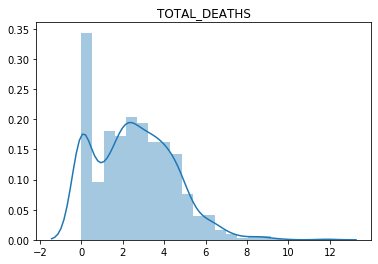

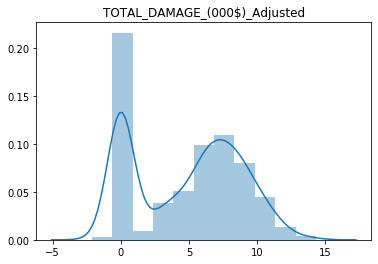

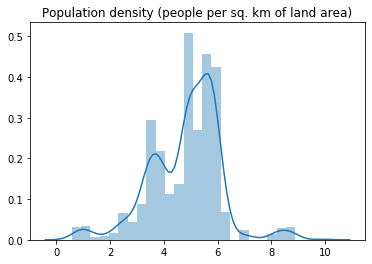

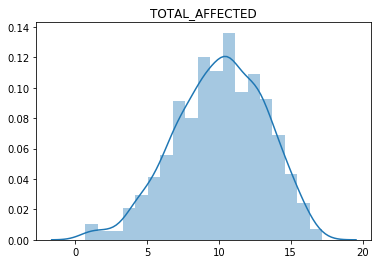

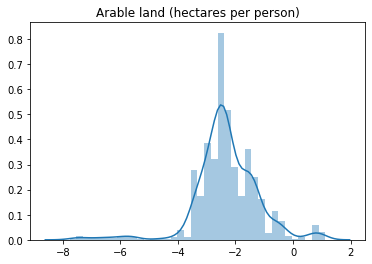

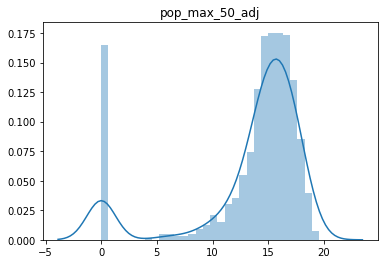

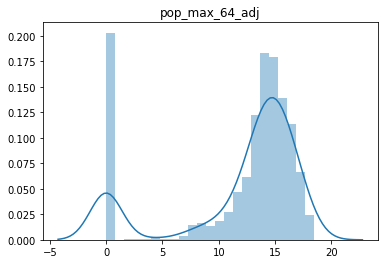

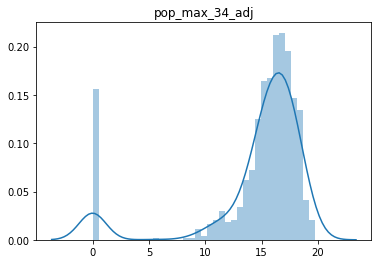

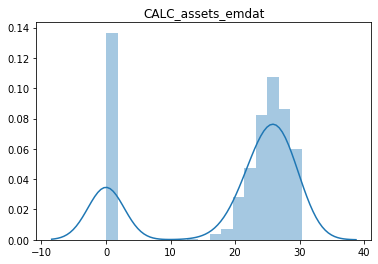

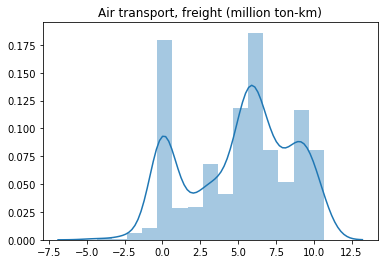

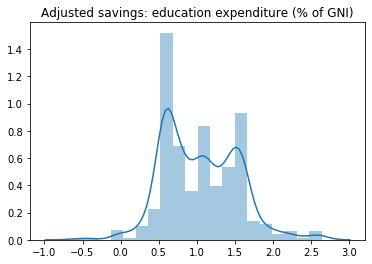

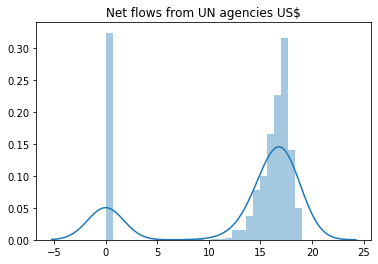

<Figure size 432x288 with 0 Axes>

In [27]:
for item in feats_to_log:
    ax=sns.distplot(df[item].values)
    ax.set_title(item);
    plt.show()
    plt.clf()


In [28]:
df.describe()

,MONTH,TOTAL_HRS,DAY_HRS,NIGHT_HRS,WIND_CALC_MEAN,PRES_CALC_MEAN,STORM_SPD_MEAN,STORM_DR_MEAN,V_LAND_KN,TOTAL_DAMAGE_(000$)_Adjusted,...,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final,pop_max_34_adj,pop_max_50_adj,pop_max_64_adj,TOTAL_AFFECTED
count,1005.000000,1005.000000,1005.000000,1005.000000,1001.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,...,1001.000000,996.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,7.780100,13.187065,2.121393,11.065672,59.718462,975.450806,12.047601,215.481903,90.011543,4.794660,...,70.647402,43.296536,4.822743,1.042842,47.065884,2.503483,14.631129,13.499296,11.878991,10.066149
std,2.762945,7.412493,3.811702,8.259346,25.080155,56.845274,6.586180,96.090666,31.633313,3.903735,...,7.252531,47.524739,1.309935,0.489732,22.016753,0.962048,4.814758,5.155078,5.670352,3.115599
min,1.000000,0.000000,0.000000,-1.000000,18.620690,0.000000,1.565217,2.000000,30.000000,-2.130005,...,41.762000,0.000000,0.580154,-0.618261,0.000000,1.000000,0.000000,0.000000,0.000000,0.693147
25%,7.000000,6.000000,0.000000,3.000000,40.000000,966.400000,7.666667,153.800000,62.400000,0.000000,...,67.136150,0.052346,3.915781,0.609766,23.959000,2.000000,14.528234,13.281251,11.422144,8.006368
50%,8.000000,15.000000,0.000000,9.000000,55.250000,981.857143,10.666667,260.750000,89.200000,5.725932,...,71.063000,27.669708,4.973857,1.019420,53.525000,2.000000,16.073350,15.124862,14.073306,10.308953
75%,10.000000,21.000000,3.000000,21.000000,75.705882,993.571429,14.411765,288.250000,114.700000,7.978456,...,75.164000,83.671391,5.710401,1.436671,64.917000,3.000000,17.255692,16.562401,15.490598,12.421418
max,12.000000,23.000000,12.000000,23.000000,150.000000,1013.000000,49.800000,358.000000,171.800000,14.307998,...,84.680488,328.790446,9.927193,2.639771,92.421000,4.000000,19.746421,19.590919,18.491778,17.204028


- **Apply min_max_scaler**

In [29]:
#df.shape

In [30]:
'''
# first we split df into categorical and numerical features, to merge later
df_cat = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')
'''

"\n# first we split df into categorical and numerical features, to merge later\ndf_cat = df.select_dtypes(include='object')\ndf_num = df.select_dtypes(exclude='object')\n"

In [31]:
# min_max_scaler = preprocessing.MinMaxScaler()

In [32]:
# cols_num = df_num.columns #we'll use this later
# cols_num

In [33]:
# X = df_num.values
# x_scaled = min_max_scaler.fit_transform(X)
# df_num = pd.DataFrame(x_scaled)

In [ ]:
# df_num.head()

In [ ]:
# df_num.rename(columns = dict(zip(df_num.columns, cols_num)), inplace = True)

In [ ]:
# df_num.head(5)

In [ ]:
# df_num.shape

In [ ]:
# df_cat.shape

Merging again df_num and df_cat

In [ ]:
# df_scaled = pd.merge(df_cat, df_num, how='inner', left_index=True, right_index=True)

In [ ]:
# df_scaled.head(20)

In [ ]:
# df_scaled.shape

- **One hot encoding for categorical variables**

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 33 columns):
BASIN                                                  1005 non-null category
SUB BASIN                                              1005 non-null category
NATURE                                                 1005 non-null category
MONTH                                                  1005 non-null int32
TOTAL_HRS                                              1005 non-null int64
DAY_HRS                                                1005 non-null int64
NIGHT_HRS                                              1005 non-null int64
USA_SSHS                                               998 non-null category
WIND_CALC_MEAN                                         1001 non-null float64
PRES_CALC_MEAN                                         1005 non-null float64
STORM_SPD_MEAN                                         1005 non-null float64
STORM_DR_MEAN                                      

In [35]:
cat_feats = df.dtypes[df.dtypes == 'category'].index
cat_feats

Index(['BASIN', 'SUB BASIN', 'NATURE', 'USA_SSHS'], dtype='object')

In [36]:
feats_to_dummy = cat_feats #selecting feats to make one-hot encoding

for feature in feats_to_dummy:
    dummy = pd.get_dummies(df[feature], prefix=feature)
    df = pd.concat([df,dummy], axis=1)

In [37]:
# Dropping dummed features
df = df.drop(feats_to_dummy, axis=1)

In [38]:
df.columns

Index(['MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'WIND_CALC_MEAN',
       'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN',
       'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', 'TOTAL_DEATHS',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 'TOTAL_AFFECTED',
       'BASIN_EP', 'BASIN_NAm', 'BASIN_NI', 'BASIN_SI', 'BASIN_SP', 'BASIN_WP',
       'SUB BASIN_AS', 'SUB BASIN_BB'

In [39]:
df.shape

(1005, 63)

In [40]:
#Droping Basin and keeping subBasin because has higher granularity,
#column arrangement 
df = df[[
    
     # here columns from cyclones dataset:
    'TOTAL_DEATHS',
    'MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'WIND_CALC_MEAN',
       'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN',
       'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', 
    
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
       'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS', 'USA_SSHS_-4.0', 'USA_SSHS_-3.0', 'USA_SSHS_-2.0',
       'USA_SSHS_-1.0', 'USA_SSHS_0.0', 'USA_SSHS_1.0', 'USA_SSHS_2.0',
       'USA_SSHS_3.0', 'USA_SSHS_4.0', 'USA_SSHS_5.0',

         
    # here columns from World Bank Indicators dataset:
     'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
         
    #  here columns from climada:
        'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj',

    # Target   
       'TOTAL_AFFECTED']]

In [41]:
df.shape

(1005, 57)

### Feature selection

In [42]:
df.columns

Index(['TOTAL_DEATHS', 'MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat',
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
       'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS', 'USA_SSHS_-4.0', 'USA_SSHS_-3.0', 'USA_SSHS_-2.0',
       'USA_SSHS_-1.0', 'USA_SSHS_0.0', 'USA_SSHS_1.0', 'USA_SSHS_2.0',
       'USA_SSHS_3.0', 'USA_SSHS_4.0', 'USA_SSHS_5.0',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life ex

In [43]:
# choosing the features to include in the model
# We take out 'TOTAL_DEATHS' because this input will not be available at the time of prediction, 
# also deleding columns with high nans

features1 = [   
     # here columns from cyclones dataset:
    'MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'WIND_CALC_MEAN',
       'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN',
    
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
       'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS', 'USA_SSHS_-4.0', 'USA_SSHS_-3.0', 'USA_SSHS_-2.0',
       'USA_SSHS_-1.0', 'USA_SSHS_0.0', 'USA_SSHS_1.0', 'USA_SSHS_2.0',
       'USA_SSHS_3.0', 'USA_SSHS_4.0', 'USA_SSHS_5.0',

         
    # here columns from World Bank Indicators dataset:
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 
       'GDP per capita (constant 2010 US$)', 
       'Life expectancy at birth, total (years)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
         
    #  here columns from climada:
        'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj'
         ]

In [44]:
features_boruta = [ 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN', 
                   'Air transport, freight (million ton-km)', 'Arable land (hectares per person)', 
                   'Cereal yield (kg per hectare)', 'Food production index (2004-2006 = 100)', 'GDP growth (annual %)', 
                   'GDP per capita (constant 2010 US$)', 'Life expectancy at birth, total (years)', 
                   'Mobile cellular subscriptions (per 100 people)', 'Population density (people per sq. km of land area)', 
                   'Adjusted savings: education expenditure (% of GNI)', 
                   'Rural population (% of total population)', 
                   'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj']


In [45]:
df = df[df['TOTAL_AFFECTED'] >0]

In [46]:
#some checks....
df['SUB BASIN_NAm'].unique()

array([0, 1], dtype=uint64)

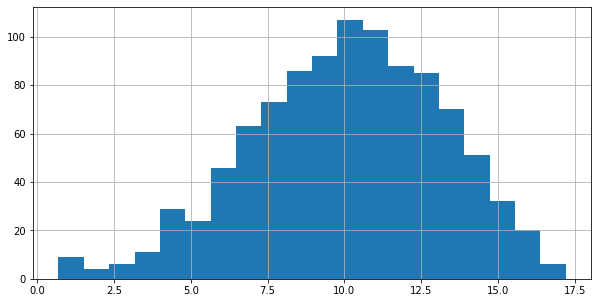

In [47]:
#some checks....
df['TOTAL_AFFECTED'].hist(bins=20, figsize=(10,5)) #this is logarithmic and scaled(0,1)

__________________

________________________

## Random forest model____________________________________

In [48]:
 #trim. Scaled and logged 1000 < x <5000000
# df_scaled =  df_scaled[df_scaled['TOTAL_AFFECTED'] > 0.4] 
# df_scaled =  df_scaled[df_scaled['TOTAL_AFFECTED'] < 0.9]
df.shape

(1005, 57)

In [49]:
# df_scaled.dropna(inplace = True)

In [50]:
from sklearn.impute import KNNImputer

In [51]:
imputer = KNNImputer(n_neighbors=5)
df_filled = pd.DataFrame(imputer.fit_transform(df))
df_filled.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,6.037871,6.0,0.0,0.0,0.0,39.133333,1000.333333,19.0,91.444444,99.820,...,67.666098,45.385395,5.556488,1.053572,36.728,1.0,16.298999,15.574055,15.015749,12.175851
1,6.232448,9.0,6.0,0.0,6.0,76.400000,974.833333,23.0,37.666667,99.820,...,67.666098,45.385395,5.556488,1.053572,36.728,1.0,17.268928,16.562266,16.136855,13.372526
2,5.036953,8.0,15.0,0.0,15.0,88.500000,974.500000,15.5,283.500000,132.400,...,64.770000,18.684943,5.026861,0.947132,66.231,1.0,14.339791,14.338512,13.993700,9.913438
3,6.343880,12.0,15.0,0.0,15.0,84.488235,979.549020,3.0,161.647059,119.200,...,61.105000,0.000000,4.511574,1.014409,69.703,2.0,15.375766,14.916344,13.924162,11.002100
4,2.944439,7.0,3.0,2.0,1.0,83.920000,980.600000,10.8,291.400000,110.691,...,61.105000,0.000000,4.511574,1.014409,69.703,2.0,15.450771,14.841368,14.502903,4.634729


In [52]:
df_filled = df_filled.rename(columns = dict(zip(df_filled.columns, df.columns), inplace = True))

In [53]:
X = df_filled[features1] #features
# X = df_scaled[features3].fillna(df.mean())
y = df_filled['TOTAL_AFFECTED']

In [54]:
X.columns

Index(['MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'WIND_CALC_MEAN',
       'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN',
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
       'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS', 'USA_SSHS_-4.0', 'USA_SSHS_-3.0', 'USA_SSHS_-2.0',
       'USA_SSHS_-1.0', 'USA_SSHS_0.0', 'USA_SSHS_1.0', 'USA_SSHS_2.0',
       'USA_SSHS_3.0', 'USA_SSHS_4.0', 'USA_SSHS_5.0',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)',
       'Life expectancy at birth, total (years)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (%

In [55]:
X.shape

(1005, 49)

In [56]:
# X.to_csv(r'Data_output/X.csv', index = False, sep = ';')

In [57]:
def RF_model(X_train, X_test, y_train, y_test):
    
    estimator_RF = RandomForestRegressor(n_estimators=1000)
    estimator_RF.fit(X_train,y_train)
    print(f"R-squared for train set: {estimator_RF.score(X, y):.2f}")
    print("--------------------------------------------")
    y_pred = estimator_RF.predict(X_test)
    print("------Feature importances---------------------")
    print(estimator_RF.feature_importances_)
    print("--------------------------------------------")
    score_estimator = estimator_RF.score(X_test, y_test)
    print("R-squared for test set =", score_estimator)
    mse = mean_squared_error(y_test,y_pred)
    print("RF estimator mean_squared_error = ", mse)
    rmse = math.sqrt(mse)
    print("RF estimator root_mean_squared_error = ", rmse)
    cvs = cross_val_score(estimator_RF, X, y, scoring= 'neg_root_mean_squared_error').mean()
    print("cross_val =neg_root_mean_squared_error mean = ", cvs)
    
    
    ##################### Plotting results #########################
    df_y = pd.DataFrame(y_test) 
    
    # Visualising the Random Forest Regression results  
    df_y['Pred_Total_Affected'] = y_pred 
    df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
    df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
    plt.figure(figsize=(12,8))
    plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
    plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
    plt.xlabel('Observations')
    plt.ylabel('log(Num_Affected')
    plt.title('log(Num Affected) - Test Vs Predictions')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()
    
    feat_importances = pd.Series(estimator_RF.feature_importances_, index = features1)
    feat_importances.nlargest(25).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "slategrey",
                                       title = "Feature importance" )
      
    return

R-squared for train set: 0.74
--------------------------------------------
------Feature importances---------------------
[1.85063756e-02 1.29810229e-02 9.51111842e-03 1.90868486e-02
 3.81307822e-02 6.59300432e-02 4.87906287e-02 4.80304902e-02
 5.46252893e-02 3.05722492e-04 1.46456357e-03 8.28478252e-06
 1.02440101e-03 1.64922302e-04 4.89436216e-04 1.35045808e-03
 1.54034511e-03 3.39098715e-04 5.68115296e-04 5.07801217e-05
 3.52038969e-03 3.05657182e-05 1.05963396e-03 6.11199578e-05
 1.09845246e-03 8.61397660e-05 1.84668604e-03 2.73662283e-04
 7.71839643e-04 5.15250911e-05 4.22428847e-03 3.90817409e-03
 3.56793934e-03 3.79014003e-03 1.87260559e-03 1.45610196e-03
 3.61370103e-04 8.25283428e-02 5.72023036e-02 3.76635737e-02
 6.99437293e-02 2.81356192e-02 3.76223602e-02 3.35424691e-02
 4.41518972e-02 2.90688651e-03 1.15945854e-01 8.32238127e-02
 5.62537910e-02]
--------------------------------------------
R-squared for test set = 0.3255612619588929
RF estimator mean_squared_error =  6.113

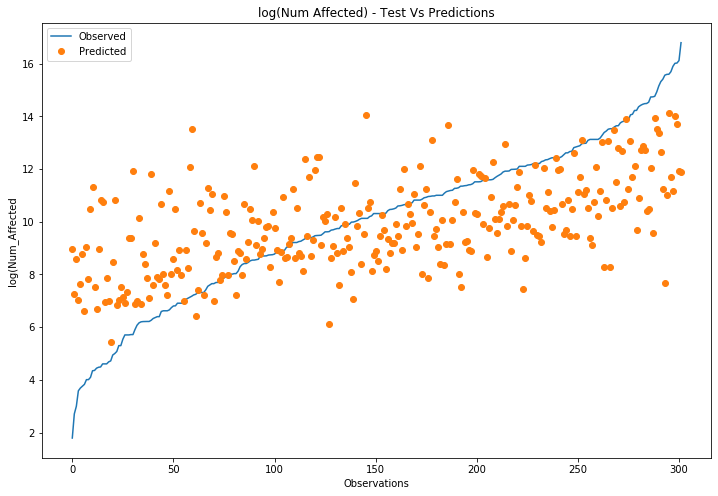

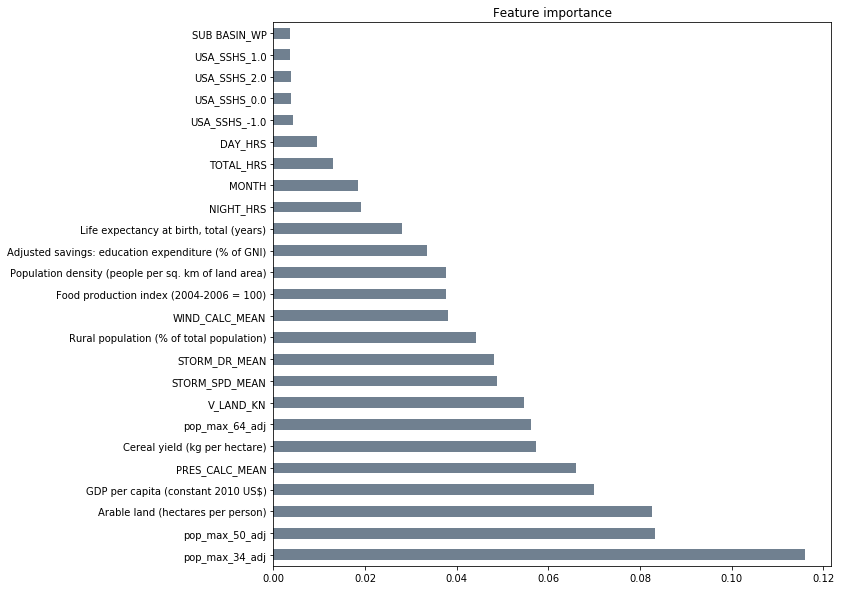

In [58]:
# Applying train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# calling the function that biulds, fits and shows results
RF_model(X_train, X_test, y_train, y_test)

# PCA______________________

# need for scaling before applying PCA

In [ ]:
#from sklearn.decomposition import PCA

In [ ]:
#X.shape

In [ ]:
# pca = PCA(n_components=1)
# principalComponents = pca.fit_transform(X)
#X_pca = pd.DataFrame(data = principalComponents)
             #, columns = ['pc1', 'pc2'])

In [ ]:
#pca.explained_variance_ratio_.sum()

In [ ]:
#X_pca.head()

... let's try the Random Forest model using the PCAs as features

In [ ]:
# Applying train/test split
#X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3)

In [ ]:
'''
estimator_RF = RandomForestRegressor(n_estimators=1000)
estimator_RF.fit(X_train,y_train)
print(f"R-squared for train set: {estimator_RF.score(X_pca, y):.2f}")
print("--------------------------------------------")
y_pred = estimator_RF.predict(X_test)
print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)
print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)
mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)
rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)
cvs = cross_val_score(estimator_RF, X_pca, y).mean()
print("cross_val_score R-squared mean = ", cvs)
'''

In [ ]:
'''
##################### Plotting results #########################

df_y = pd.DataFrame(y_test)
df_y['Pred_Total_Affected'] = y_pred
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
# plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('Num_Affected')
plt.title('Num Affected - Test Vs Predictions')
# show a legend on the plot
plt.legend()

# Display  figure
plt.show()
'''

### Hyperparameter tunning with grid search

In [78]:
X = df_filled[features1] #features
# X = df_scaled[features3].fillna(df.mean())
y = df_filled['TOTAL_AFFECTED']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #(X_pca, y, test_size=0.3)

In [80]:
parameters = {'n_estimators':[100, 500, 1000], 
              'max_depth':[5, 10, 20],
              'max_features':[10, 15, 20]              
             }

In [81]:
estimator_RF = GridSearchCV(RandomForestRegressor(), parameters, cv = 3, scoring= 'neg_root_mean_squared_error',
                            return_train_score = False)

In [82]:
estimator_RF.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [83]:
GS_results = pd.DataFrame(estimator_RF.cv_results_)
GS_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [84]:
cols_needed = ['param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_test_score','rank_test_score']
GS_results = GS_results[cols_needed]
GS_results.sort_values(by=['rank_test_score'], ascending = True)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,rank_test_score
19,20,10,500,-2.633980,1
20,20,10,1000,-2.634703,2
10,10,10,500,-2.638217,3
26,20,20,1000,-2.639292,4
22,20,15,500,-2.639830,5
25,20,20,500,-2.641487,6
16,10,20,500,-2.643034,7
23,20,15,1000,-2.643417,8
13,10,15,500,-2.643759,9
17,10,20,1000,-2.644277,10


### Using best parameters from GridSearchCV to fit and predict

In [85]:
estimator_RF = RandomForestRegressor(n_estimators=1000, max_features=10, max_depth=20)
estimator_RF.fit(X_train,y_train)

print(f"R-squared for train set: {estimator_RF.score(X, y):.2f}")
print("--------------------------------------------")

y_pred = estimator_RF.predict(X_test)

print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)

print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)

mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)

rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)

cvs = cross_val_score(estimator_RF, X, y, scoring= 'neg_root_mean_squared_error').mean()
print("cross_val_score =neg_root_mean_squared_error mean = ", cvs)

R-squared for train set: 0.73
--------------------------------------------
------Feature importances---------------------
[2.09522315e-02 1.68552817e-02 1.57465088e-02 1.96699050e-02
 4.45801768e-02 5.08653064e-02 4.98276037e-02 4.49315465e-02
 4.83539839e-02 3.34211130e-04 1.54388353e-03 7.00299415e-05
 2.44448254e-03 2.73234130e-04 8.73030148e-04 1.87510053e-03
 1.42999616e-03 1.12903470e-03 1.91645365e-03 1.26221797e-04
 5.97710000e-03 3.41545998e-04 1.24956307e-03 1.31969867e-04
 1.49117208e-03 5.36481850e-05 2.23508310e-03 1.15381647e-03
 2.20896037e-03 9.37460008e-05 5.03982463e-03 5.10750053e-03
 5.66725002e-03 4.75050252e-03 1.52236922e-03 2.36392023e-03
 5.03861897e-04 5.96666292e-02 5.00533410e-02 3.85715215e-02
 6.55208154e-02 4.25308768e-02 4.69990617e-02 4.41116007e-02
 5.70487437e-02 2.02572406e-02 7.72535334e-02 7.01879369e-02
 6.41086422e-02]
--------------------------------------------
R-squared for test set = 0.3723185085521127
RF estimator mean_squared_error =  6.567

In [86]:
# df_y.to_csv(r'Data_output/ytest_Vs_ypred_YY.csv', index = False, sep = ';')

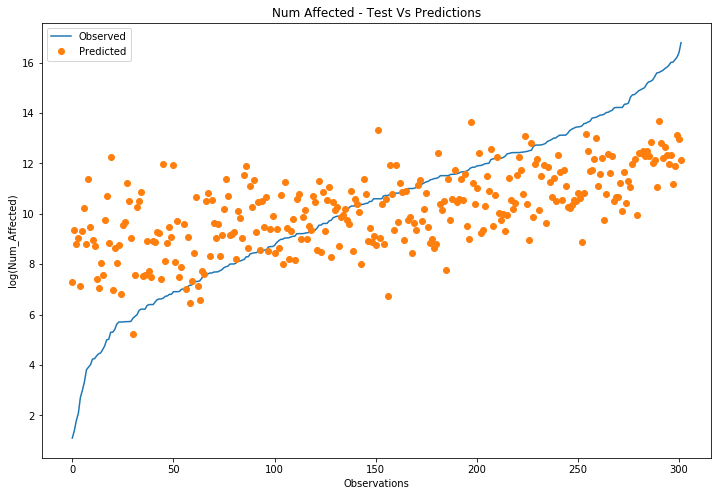

In [87]:
df_y = pd.DataFrame(y_test) 
    
    # Visualising the Random Forest Regression results  
df_y['Pred_Total_Affected'] = y_pred 
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('log(Num_Affected)')
#plt.xlim(0,100)
plt.title('Num Affected - Test Vs Predictions')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()
    


In [88]:
df_y.to_csv(r'Data_output/ytest_Vs_ypred.csv', index = False, sep = ';')

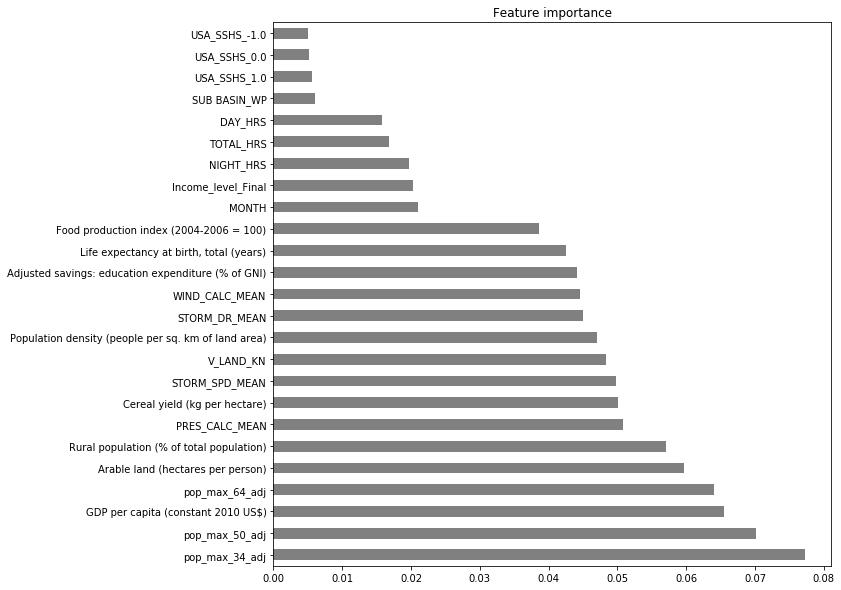

In [89]:
feat_importances = pd.Series(estimator_RF.feature_importances_, index = features1)
feat_importances.nlargest(25).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "grey",
                                       title = "Feature importance" )

- Plotting with another chart

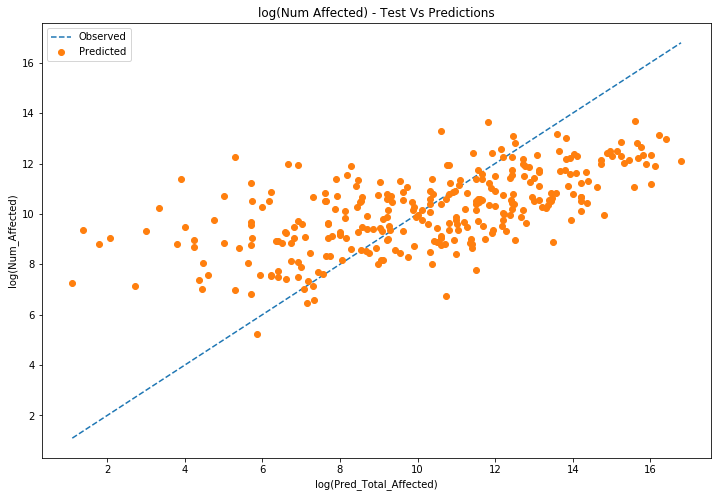

In [90]:
df_y = pd.DataFrame(y_test) 
    
    # Visualising the Random Forest Regression results  
df_y['Pred_Total_Affected'] = y_pred 
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y['TOTAL_AFFECTED'], df_y['TOTAL_AFFECTED'], '--', label = 'Observed')
plt.plot(df_y['TOTAL_AFFECTED'], df_y['Pred_Total_Affected'], 'o', label = 'Predicted')

plt.xlabel('log(Pred_Total_Affected)')
plt.ylabel('log(Num_Affected)')
#plt.xlim(0,100)
plt.title('log(Num Affected) - Test Vs Predictions')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()

- Plotting MAE of each observed data point in test data

In [91]:
df_y['error'] = abs(df_y['Pred_Total_Affected'] - df_y['TOTAL_AFFECTED'])

In [92]:
df_y['error'].describe()

count    302.000000
mean       2.048228
std        1.542791
min        0.018324
25%        0.896724
50%        1.811225
75%        2.832713
max        7.968196
Name: error, dtype: float64

No handles with labels found to put in legend.


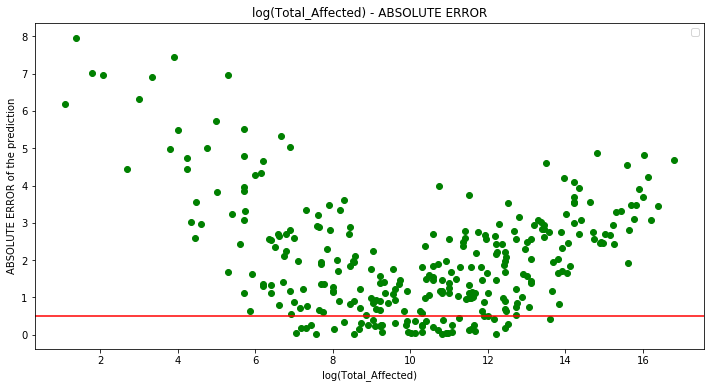

In [93]:
plt.figure(figsize=(12,6))
plt.plot(df_y['TOTAL_AFFECTED'], df_y['error'] , 'og')
plt.axhline(y=0.5,c='r')
plt.xlabel('log(Total_Affected)')
plt.ylabel('ABSOLUTE ERROR of the prediction')
#plt.xlim(0,100)
plt.title('log(Total_Affected) - ABSOLUTE ERROR')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()

### Oversampling in train dataset to see if we can improve model performance in boundaries of y-values 

In [95]:
X = df_filled[features1] #features
# X = df_scaled[features3].fillna(df.mean())
y = df_filled['TOTAL_AFFECTED']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #(X_pca, y, test_size=0.3)

In [97]:
X_train['y_train'] = pd.DataFrame(y_train)

C:\Users\torre\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [98]:
# oversampling only low and high values
X_train = X_train.append(X_train[X_train['y_train'] < 2]).append(X_train[X_train['y_train'] > 5])
y_train = X_train['y_train']
X_train = X_train.drop('y_train', axis = 1)

In [99]:
X_train.shape

(1369, 49)

In [100]:
estimator_RF = RandomForestRegressor(n_estimators=1000)
estimator_RF.fit(X_train,y_train)

print(f"R-squared for train set: {estimator_RF.score(X, y):.2f}")
print("--------------------------------------------")

y_pred = estimator_RF.predict(X_test)

print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)

print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)

mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)

rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)

cvs = cross_val_score(estimator_RF, X, y, scoring= 'neg_root_mean_squared_error').mean()
print("cross_val_score =neg_root_mean_squared_error mean = ", cvs)

R-squared for train set: 0.76
--------------------------------------------
------Feature importances---------------------
[1.98560101e-02 1.29256071e-02 1.00827249e-02 1.50952703e-02
 3.37999225e-02 6.05724442e-02 5.77085306e-02 4.40161373e-02
 5.85393926e-02 3.26111776e-04 1.52017090e-03 6.30132913e-06
 2.44993674e-03 7.03943250e-05 3.88878929e-04 9.85248015e-03
 1.27769929e-03 5.36130460e-04 4.05627210e-04 1.05323712e-03
 3.55979988e-03 3.70573174e-05 4.01813506e-04 8.88124843e-05
 5.52530360e-04 1.65458071e-04 1.32309732e-03 7.07868523e-04
 1.15704206e-03 2.39297712e-04 3.28921162e-03 4.13350336e-03
 5.39644719e-03 6.09411046e-03 8.15526702e-04 6.85716847e-04
 2.35864954e-04 5.30705260e-02 6.21594520e-02 3.70176215e-02
 1.23314484e-01 2.67289396e-02 3.39293985e-02 2.53417872e-02
 4.96691348e-02 3.96721929e-03 9.57538700e-02 6.69003970e-02
 6.27810046e-02]
--------------------------------------------
R-squared for test set = 0.2733595810956809
RF estimator mean_squared_error =  6.928

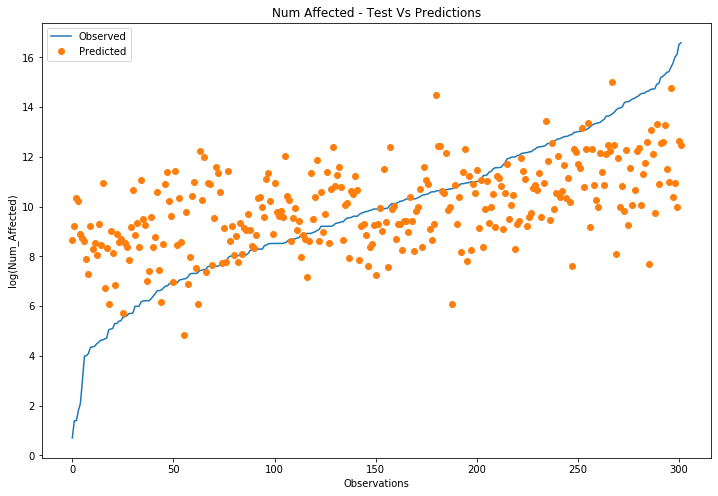

In [101]:
df_y = pd.DataFrame(y_test) 
    
    # Visualising the Random Forest Regression results  
df_y['Pred_Total_Affected'] = y_pred 
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('log(Num_Affected)')
#plt.xlim(0,100)
plt.title('Num Affected - Test Vs Predictions')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()

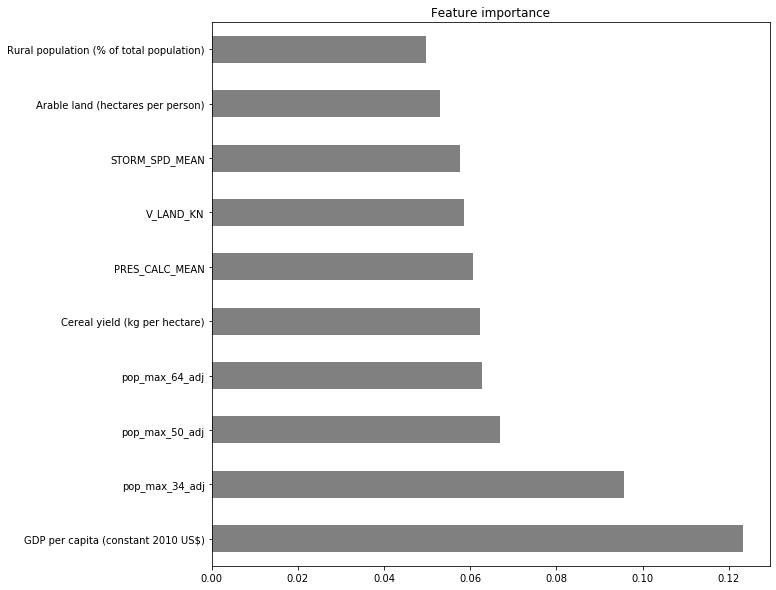

In [102]:
feat_importances = pd.Series(estimator_RF.feature_importances_, index = features1)
feat_importances.nlargest(10).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "grey",
                                       title = "Feature importance" )

#### __________Oversamplig strategy doesn't work____________

### Using Sequential Feature Selection

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [103]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [104]:
# df_filled =  df_filled[df_filled['TOTAL_AFFECTED'] > 0.4] 
# df_filled =  df_filled[df_filled['TOTAL_AFFECTED'] < 0.9]

In [105]:
df_filled.shape

(1005, 57)

In [106]:
X = df_filled[features1] #features
# X = df_scaled[features3].fillna(df.mean())
y = df_filled['TOTAL_AFFECTED']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #(X_pca, y, test_size=0.3)

In [108]:
estimator_RF = RandomForestRegressor(n_estimators=1000)

In [109]:
sfs1 = SFS(estimator_RF, 
           k_features=10, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='neg_root_mean_squared_error',
           cv=0)

In [110]:
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:  2.4min finished

[2020-05-01 00:17:18] Features: 1/10 -- score: -1.4722094053900119[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished

[2020-05-01 00:21:00] Features: 2/10 -- score: -1.1364003379259273[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_

In [111]:
sfs1.subsets_

{1: {'feature_idx': (4,),
  'cv_scores': array([-1.47220941]),
  'avg_score': -1.4722094053900119,
  'feature_names': ('WIND_CALC_MEAN',)},
 2: {'feature_idx': (4, 42),
  'cv_scores': array([-1.13640034]),
  'avg_score': -1.1364003379259273,
  'feature_names': ('WIND_CALC_MEAN',
   'Population density (people per sq. km of land area)')},
 3: {'feature_idx': (4, 42, 46),
  'cv_scores': array([-1.04892175]),
  'avg_score': -1.0489217516567095,
  'feature_names': ('WIND_CALC_MEAN',
   'Population density (people per sq. km of land area)',
   'pop_max_34_adj')},
 4: {'feature_idx': (4, 40, 42, 46),
  'cv_scores': array([-0.97810834]),
  'avg_score': -0.9781083421513599,
  'feature_names': ('WIND_CALC_MEAN',
   'GDP per capita (constant 2010 US$)',
   'Population density (people per sq. km of land area)',
   'pop_max_34_adj')},
 5: {'feature_idx': (4, 40, 42, 43, 46),
  'cv_scores': array([-0.97128705]),
  'avg_score': -0.9712870482584411,
  'feature_names': ('WIND_CALC_MEAN',
   'GDP per c

In [112]:
#TOP_10 Selected features
top_10_features = list(sfs1.k_feature_names_)
top_10_features

['MONTH',
 'WIND_CALC_MEAN',
 'PRES_CALC_MEAN',
 'NATURE_NR',
 'USA_SSHS_2.0',
 'GDP per capita (constant 2010 US$)',
 'Population density (people per sq. km of land area)',
 'Adjusted savings: education expenditure (% of GNI)',
 'pop_max_34_adj',
 'pop_max_64_adj']

In [113]:
# df_filled_trim =  df_filled[(df_filled['TOTAL_AFFECTED']>2) & (df_filled['TOTAL_AFFECTED']<5)]

In [114]:
X = df_filled[top_10_features] #features
# X = df_scaled[features3].fillna(df.mean())
y = df_filled['TOTAL_AFFECTED']

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #(X_pca, y, test_size=0.3)

In [116]:
estimator_RF = RandomForestRegressor(n_estimators=1000)
estimator_RF.fit(X_train,y_train)

print(f"R-squared for train set: {estimator_RF.score(X, y):.2f}")
print("--------------------------------------------")

y_pred = estimator_RF.predict(X_test)

print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)

print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)

mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)

rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)

cvs = cross_val_score(estimator_RF, X, y, scoring= 'neg_root_mean_squared_error').mean()
print("cross_val_score =neg_root_mean_squared_error mean = ", cvs)

R-squared for train set: 0.72
--------------------------------------------
------Feature importances---------------------
[0.0491805  0.09914524 0.11412871 0.00371465 0.00601973 0.1990891
 0.14828655 0.08213566 0.18586685 0.11243301]
--------------------------------------------
R-squared for test set = 0.34354363950848443
RF estimator mean_squared_error =  6.78829707044508
RF estimator root_mean_squared_error =  2.6054360614770573
cross_val_score =neg_root_mean_squared_error mean =  -2.7165929733657768


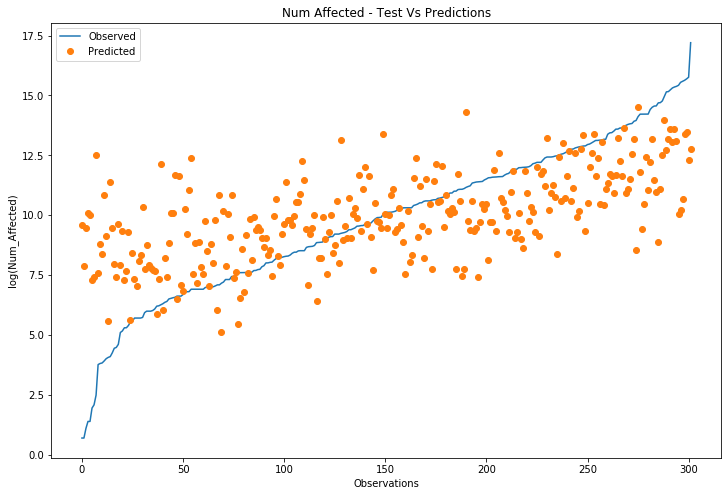

In [117]:
df_y = pd.DataFrame(y_test) 
    
    # Visualising the Random Forest Regression results  
df_y['Pred_Total_Affected'] = y_pred 
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('log(Num_Affected)')
#plt.xlim(0,100)
plt.title('Num Affected - Test Vs Predictions')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()

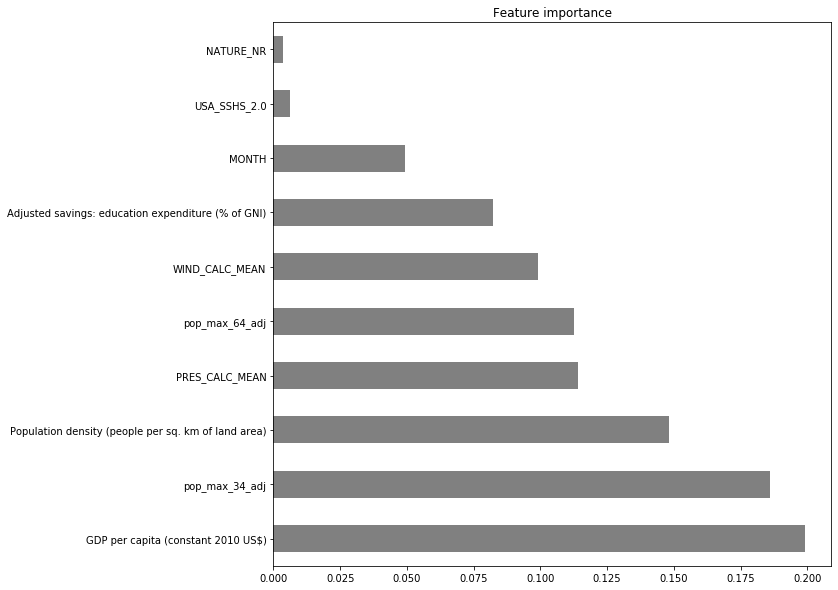

In [118]:
feat_importances = pd.Series(estimator_RF.feature_importances_, index = top_10_features)
feat_importances.nlargest(10).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "grey",
                                       title = "Feature importance" )

## RANSAC Regressor (works if target has outliers?)

In [119]:
from sklearn import linear_model

In [120]:
# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X_train, y_train)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models

y_pred = ransac.predict(X_test)

In [121]:
print("--------------------------------------------")
score_estimator = ransac.score(X_test, y_test)
print("R-squared for test set =", score_estimator)

mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)

rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)

cvs = cross_val_score(ransac, X, y, scoring= 'neg_root_mean_squared_error').mean()
print("cross_val_score mean = ", cvs)

--------------------------------------------
R-squared for test set = -0.1446176223384903
RF estimator mean_squared_error =  11.836284816682205
RF estimator root_mean_squared_error =  3.4403902128511827
cross_val_score mean =  -7.412006730088761


###  ________________**Nope, ransac doesn't work**__________________

___________________________
________________________________